In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
!pip3 install resampy
import resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.2 MB/s eta 0:00:00


In [3]:
!pip3 install librosa

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
mylist= os.listdir('/content/drive/MyDrive/RAVDESS')

In [7]:
print(mylist[1200])

03-01-07-02-01-02-05.wav


In [8]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/RAVDESS/03-01-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


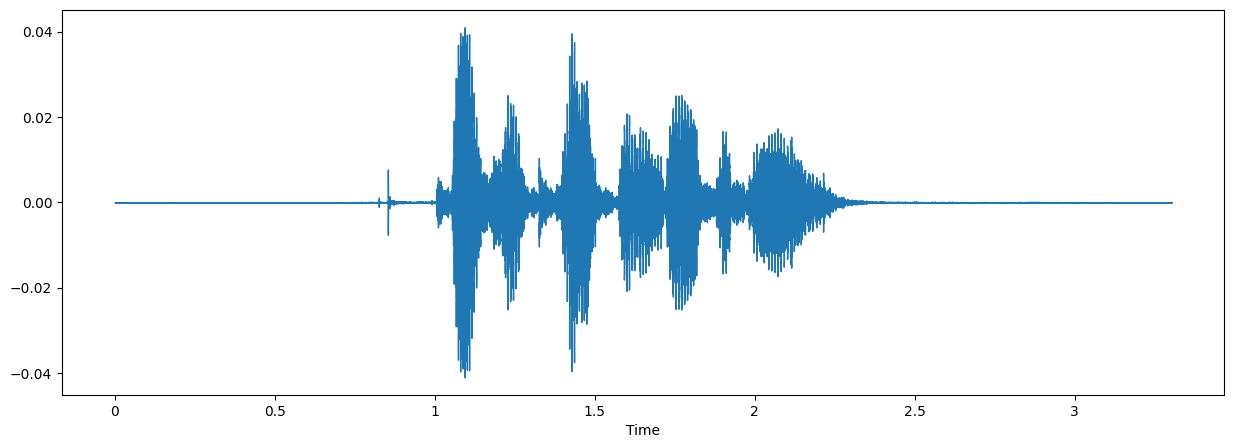

In [9]:
%pylab inline
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

<ipython-input-10-92de94d479b4>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/RAVDESS/03-01-01-01-01-02-21.wav')


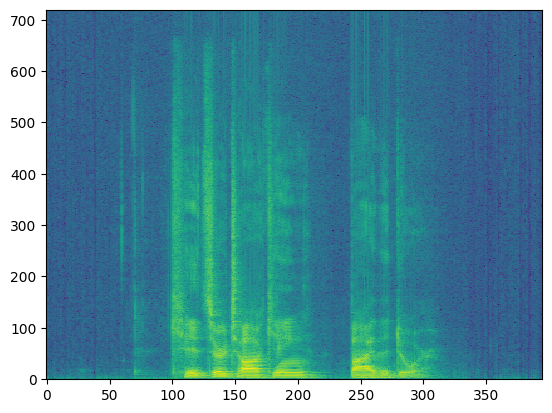

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/RAVDESS/03-01-01-01-01-02-21.wav')

nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')

In [12]:
labels = pd.DataFrame(feeling_list)


In [13]:
labels[:10]


,0
0,female_calm
1,male_calm
2,male_calm
3,female_calm
4,female_calm
5,male_calm
6,female_calm
7,female_calm
8,male_calm
9,male_calm


In [15]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08':
        X, sample_rate = librosa.load('/content/drive/MyDrive/RAVDESS/'+y,sr=22050*2, mono=True, offset=0.5, duration=2.5,res_type='soxr_hq')
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X,
                                            sr=sample_rate,
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [16]:
df[:5]

,feature
0,"[-66.24156, -66.24156, -66.24156, -66.24156, -..."
1,"[-54.679176, -53.799828, -54.171745, -54.44976..."
2,"[-55.84003, -54.437492, -53.99746, -54.537174,..."
3,"[-76.825165, -76.825165, -76.825165, -76.82516..."
4,"[-68.3269, -68.3269, -68.3269, -68.3269, -68.3..."


In [17]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [18]:
newdf = pd.concat([df3,labels], axis=1)

In [19]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [20]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,-66.241562,...,-65.673691,-66.017403,-65.757866,-65.914642,-65.938446,-65.616859,-64.205429,-64.318970,-66.241562,female_calm
1,-54.679176,-53.799828,-54.171745,-54.449760,-54.116905,-53.481525,-53.920979,-53.412399,-53.571762,-52.054565,...,-49.040012,-49.685284,-55.080715,-60.130764,-57.228962,-55.812325,-56.242325,-57.345760,-57.363262,male_calm
2,-55.840031,-54.437492,-53.997459,-54.537174,-56.044434,-53.743629,-51.133278,-53.106411,-54.393230,-55.484558,...,-53.695480,-54.101337,-53.586937,-53.994797,-52.829895,-51.829933,-52.236553,-50.564510,-45.881699,male_calm
3,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,...,-66.837204,-67.508133,-68.562698,-68.411575,-71.366104,-71.919144,-71.677811,-70.871170,-70.311829,female_calm
4,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,-68.326897,...,-52.098713,-54.630062,-61.965988,-61.396294,-57.865253,-54.481453,-57.678463,-60.142292,-63.902622,female_calm


In [21]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
894,-46.829037,-45.939968,-46.843647,-46.739494,-47.370083,-46.498005,-46.565117,-45.954239,-46.698429,-47.241520,...,-41.096684,-40.881451,-39.830235,-39.386879,-38.905960,-39.743107,-41.178913,-37.626881,-31.722652,male_fearful
431,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,-66.886887,...,-64.678314,-59.605625,-58.691048,-61.264793,-62.021187,-65.622665,-63.283691,-57.699871,-56.862328,female_sad
121,-63.236416,-61.394505,-62.447624,-64.449577,-66.766533,-67.363388,-67.470993,-66.984009,-66.917084,-67.388535,...,-31.854038,-33.356789,-32.666443,-32.838509,-33.677658,-33.249088,-32.756996,-30.768393,-28.633869,male_calm
521,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,-63.764038,...,-54.039577,-55.678543,-56.245319,-58.996952,-55.482101,-54.130356,-54.817951,-53.517536,-49.758934,female_sad
389,-39.694824,-41.224808,-47.781151,-47.869381,-48.522408,-49.264889,-50.617310,-50.912903,-50.583191,-52.068645,...,-49.007973,-49.693264,-50.796379,-51.056480,-53.020878,-48.178284,-47.041084,-49.852657,-50.916325,male_sad
904,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,...,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,-46.439968,female_fearful
782,-41.653111,-41.726196,-41.842533,-41.789528,-41.842533,-41.842533,-41.842533,-41.130718,-39.944290,-40.545639,...,-24.798420,-26.135029,-30.699526,-32.226009,-32.936337,-31.675114,-32.871330,-34.102470,-35.740311,male_angry
607,-56.299770,-54.519142,-52.649643,-51.412605,-52.617741,-50.657917,-49.833168,-50.208305,-50.345284,-50.000896,...,-33.230789,-32.634285,-31.710747,-31.252476,-32.066761,-31.905333,-31.958164,-30.409609,-27.558739,female_angry
82,-50.162155,-53.070744,-57.426052,-60.287735,-63.516155,-59.824608,-59.657242,-60.266747,-60.923916,-63.634171,...,-66.581848,-65.910347,-65.689796,-59.149075,-57.584652,-60.387589,-62.522095,-63.578598,-65.220512,male_calm
598,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,-55.667412,...,-48.942417,-47.689636,-50.879238,-52.436317,-53.300156,-55.409126,-54.773758,-53.498188,-52.558533,female_angry


In [22]:
rnewdf=rnewdf.fillna(0)

In [23]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [24]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
316,-54.821358,-49.663967,-48.365089,-51.365276,-48.723171,-49.668419,-49.013309,-48.351360,-49.692825,-51.471748,...,-40.398087,-41.469402,-41.573227,-40.033813,-41.191795,-44.171333,-44.219849,-42.957283,-43.428452,female_happy
683,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,-43.614098,...,-42.087479,-42.378277,-43.341465,-42.948483,-43.228336,-43.232662,-44.129623,-43.672703,-43.332481,female_angry
753,-56.693222,-56.693222,-56.693222,-56.693222,-56.693222,-56.693222,-56.693222,-56.693222,-56.693222,-56.651962,...,-48.200436,-47.177322,-45.813435,-45.382362,-45.310112,-45.803886,-46.272446,-48.338707,-50.924831,female_fearful
700,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,-44.502018,...,-39.406643,-32.882236,-21.251617,-22.195330,-28.413548,-25.179441,-25.668243,-28.198809,-20.537777,female_angry
912,-40.560440,-38.580360,-37.441994,-37.765762,-36.840244,-36.838600,-36.750431,-37.508049,-38.381908,-38.948612,...,-29.880562,-28.953846,-28.159756,-30.603136,-31.724888,-32.375351,-31.610893,-30.774302,-26.208731,female_fearful
473,-55.298378,-55.298378,-55.298378,-55.323792,-55.298378,-55.298378,-55.336807,-55.321594,-55.298378,-55.298378,...,-32.161568,-32.065498,-37.892715,-40.404472,-40.890690,-41.840660,-43.879036,-34.580479,-25.340727,female_sad
950,-37.787918,-36.842186,-36.723713,-36.376415,-36.589748,-36.286846,-35.952248,-36.628281,-37.214870,-37.328678,...,-26.924232,-26.995005,-28.380592,-28.543365,-27.783321,-27.827852,-29.133030,-28.737417,-25.498392,female_fearful
187,-62.644783,-57.651131,-56.525017,-57.256653,-58.253342,-58.589764,-58.265259,-59.958031,-61.133503,-61.208416,...,-45.650673,-46.546463,-47.595684,-47.938705,-50.599609,-48.968094,-47.782223,-48.010067,-49.526386,female_happy
783,-44.276325,-44.276325,-44.276325,-44.276325,-44.276325,-44.276325,-44.276325,-44.276325,-44.276325,-44.206196,...,-29.632246,-30.211750,-25.398195,-23.292021,-22.933285,-25.271803,-27.270506,-20.912325,-16.228405,female_angry
3,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,-76.825165,...,-66.837204,-67.508133,-68.562698,-68.411575,-71.366104,-71.919144,-71.677811,-70.871170,-70.311829,female_calm


In [25]:
trainfeatures = train.iloc[:, :-1]

In [26]:
trainlabel = train.iloc[:, -1:]

In [27]:
testfeatures = test.iloc[:, :-1]

In [28]:
testlabel = test.iloc[:, -1:]

In [29]:
trainlabel

,0
894,male_fearful
121,male_calm
521,female_sad
389,male_sad
904,female_fearful
...,...
667,female_angry
470,female_sad
749,female_fearful
628,female_angry


In [30]:
import keras.utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = keras.utils.to_categorical(lb.fit_transform(y_train.astype(str)))
y_test = keras.utils.to_categorical(lb.fit_transform(y_test.astype(str)))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
lis2 = y_test.tolist()
y_test = np.array(lis2)

In [34]:
y_test.shape

(201, 10)

In [35]:
lis1 = y_train.tolist()
y_train = np.array(lis1)

In [36]:
y_train.shape

(759, 10)

In [37]:
X_train.shape

(759, 216)

In [38]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [39]:
from tensorflow.keras import optimizers
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = optimizers.legacy.RMSprop(learning_rate=0.00001, decay=1e-6)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 27, 128)           0         
 D)                                                              
                                                        

In [41]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [42]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=800, validation_data=(x_testcnn, y_test))

Epoch 1/800
48/48 [==============================] - 10s 182ms/step - loss: 2.4316 - accuracy: 0.0988 - val_loss: 2.3118 - val_accuracy: 0.1045
Epoch 2/800
48/48 [==============================] - 6s 123ms/step - loss: 2.3024 - accuracy: 0.1067 - val_loss: 2.2771 - val_accuracy: 0.0995
Epoch 3/800
48/48 [==============================] - 6s 116ms/step - loss: 2.2646 - accuracy: 0.1159 - val_loss: 2.2697 - val_accuracy: 0.1045
Epoch 4/800
48/48 [==============================] - 5s 104ms/step - loss: 2.2408 - accuracy: 0.1436 - val_loss: 2.2321 - val_accuracy: 0.1493
Epoch 5/800
48/48 [==============================] - 5s 97ms/step - loss: 2.2066 - accuracy: 0.1607 - val_loss: 2.2064 - val_accuracy: 0.1741
Epoch 6/800
48/48 [==============================] - 6s 126ms/step - loss: 2.1823 - accuracy: 0.1752 - val_loss: 2.1911 - val_accuracy: 0.1692
Epoch 7/800
48/48 [==============================] - 5s 108ms/step - loss: 2.1645 - accuracy: 0.1673 - val_loss: 2.1581 - val_accuracy: 0.2388

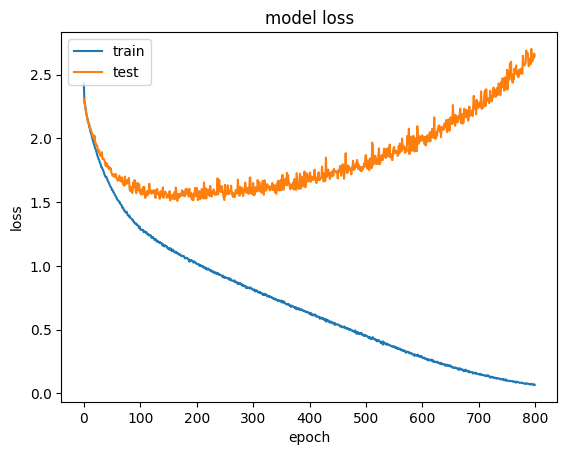

In [43]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")


loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [47]:
preds = loaded_model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

7/7 [==============================] - 0s 41ms/step


In [48]:
preds

array([[4.4915996e-02, 2.5041428e-01, 3.8324878e-01, ..., 1.5815368e-02,
        2.5627533e-02, 7.6077085e-05],
       [1.1531178e-01, 3.1040452e-04, 1.0346255e-03, ..., 3.0958113e-06,
        6.5939093e-05, 1.8881854e-05],
       [1.6256509e-10, 2.1287033e-08, 2.4257103e-08, ..., 3.4628798e-08,
        1.7714970e-06, 1.6787913e-02],
       ...,
       [8.8705164e-01, 1.3751440e-10, 8.1053041e-02, ..., 3.8041401e-04,
        2.1078975e-08, 2.8196323e-10],
       [2.5695985e-07, 1.4051181e-11, 1.0044110e-11, ..., 1.9696415e-04,
        7.4540889e-01, 2.2160243e-03],
       [4.9975874e-06, 2.6248814e-11, 4.7343341e-04, ..., 3.0386096e-07,
        8.5554109e-07, 1.9742141e-09]], dtype=float32)

In [49]:
preds1=preds.argmax(axis=1)

In [50]:
preds1

array([2, 4, 6, 0, 4, 8, 9, 9, 6, 8, 2, 0, 5, 7, 9, 9, 4, 1, 1, 3, 5, 5,
       0, 5, 1, 1, 6, 2, 0, 1, 7, 5, 3, 3, 6, 4, 3, 0, 6, 8, 6, 8, 5, 8,
       9, 6, 5, 5, 5, 7, 5, 3, 8, 0, 6, 8, 3, 1, 2, 8, 2, 1, 4, 9, 4, 2,
       9, 3, 7, 7, 7, 3, 3, 3, 9, 8, 6, 5, 0, 4, 5, 5, 0, 6, 9, 9, 5, 4,
       5, 6, 9, 5, 5, 0, 9, 1, 6, 6, 4, 8, 5, 8, 8, 9, 2, 7, 4, 8, 8, 6,
       7, 1, 1, 2, 0, 2, 6, 3, 8, 3, 2, 4, 3, 2, 7, 3, 3, 1, 6, 3, 5, 5,
       9, 0, 7, 2, 9, 5, 4, 3, 5, 1, 4, 5, 6, 4, 8, 3, 6, 5, 3, 8, 6, 0,
       0, 3, 1, 6, 1, 3, 0, 3, 9, 3, 1, 1, 2, 3, 8, 0, 2, 2, 6, 7, 2, 8,
       0, 7, 8, 2, 9, 9, 2, 9, 9, 6, 5, 6, 5, 2, 9, 1, 6, 3, 1, 4, 9, 2,
       0, 8, 3])

In [51]:
abc = preds1.astype(int).flatten()

In [52]:
predictions = (lb.inverse_transform((abc)))

In [53]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_fearful
1,female_sad
2,male_calm
3,female_angry
4,female_sad
5,male_happy
6,male_sad
7,male_sad
8,male_calm
9,male_happy


In [54]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [55]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_sad
1,female_angry
2,male_calm
3,female_angry
4,female_sad
5,male_happy
6,male_fearful
7,male_calm
8,male_angry
9,female_angry


In [56]:
finaldf = actualdf.join(preddf)

In [57]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_happy,female_fearful
171,female_happy,female_fearful
172,male_sad,male_calm
173,male_fearful,male_fearful
174,female_fearful,female_fearful
175,male_fearful,male_happy
176,female_angry,female_angry
177,male_calm,male_fearful
178,male_angry,male_happy
179,female_fearful,female_fearful


In [58]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,14
female_calm,22
female_fearful,19
female_happy,22
female_sad,17
male_angry,25
male_calm,21
male_fearful,24
male_happy,21


In [59]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,17
female_calm,18
female_fearful,20
female_happy,26
female_sad,15
male_angry,26
male_calm,24
male_fearful,12
male_happy,21


In [60]:
finaldf.to_csv('Predictions.csv', index=False)

In [61]:
data, sampling_rate = librosa.load('VRecording.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


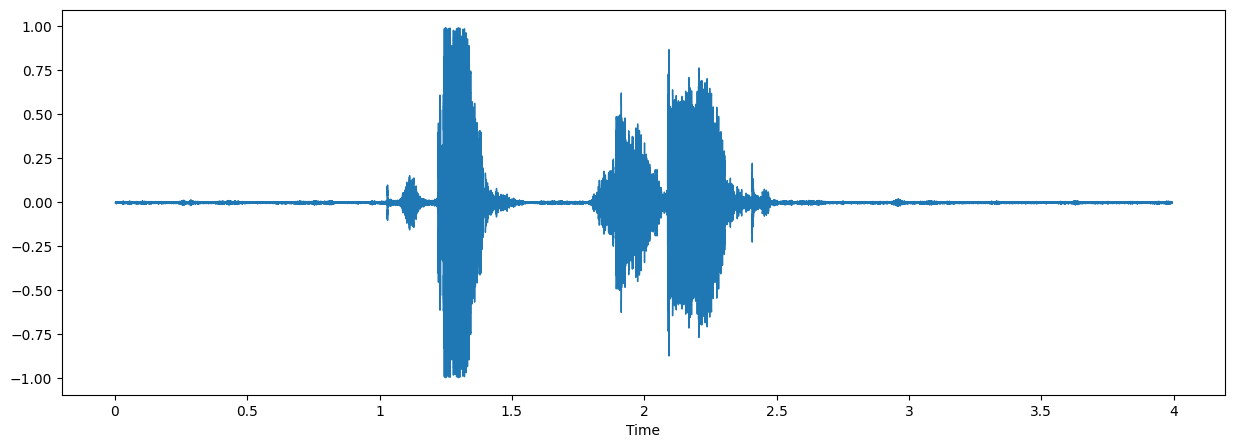

In [62]:
%pylab inline
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [64]:
X, sample_rate = librosa.load('VRecording.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [65]:
livedf2= pd.DataFrame(data=livedf2)

In [66]:
livedf2 = livedf2.stack().to_frame().T

In [67]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-25.96302,-24.707167,-24.721975,-23.151102,-24.291531,-26.485607,-28.139788,-26.242758,-24.016727,-20.750095,...,-19.886963,-21.442781,-23.800106,-21.235271,-19.260792,-16.248037,-15.576656,-16.986658,-19.538116,-21.891376


In [68]:
twodim= np.expand_dims(livedf2, axis=2)

In [69]:
livepreds = loaded_model.predict(twodim,
                         batch_size=32,
                         verbose=1)

1/1 [==============================] - 0s 45ms/step


In [70]:
livepreds

array([[1.3550797e-06, 6.7367353e-26, 2.9534730e-13, 1.3804207e-13,
        1.0737405e-21, 1.7746356e-03, 2.6027461e-12, 9.9822360e-01,
        8.5582940e-13, 4.8844078e-07]], dtype=float32)

In [71]:
livepreds1=livepreds.argmax(axis=1)

In [72]:
liveabc = livepreds1.astype(int).flatten()

In [75]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype='<U14')